Anomaly detected! Using safe control at step 1
Anomaly detected! Using safe control at step 2
Optimization warning: Inequality constraints incompatible
Anomaly detected! Using safe control at step 6
Anomaly detected! Using safe control at step 8
Optimization warning: Inequality constraints incompatible
Anomaly detected! Using safe control at step 11
Anomaly detected! Using safe control at step 12
Optimization warning: Inequality constraints incompatible
Optimization warning: Inequality constraints incompatible
Optimization warning: Inequality constraints incompatible
Anomaly detected! Using safe control at step 16
Anomaly detected! Using safe control at step 17
Anomaly detected! Using safe control at step 18
Optimization warning: Inequality constraints incompatible
Anomaly detected! Using safe control at step 20
Anomaly detected! Using safe control at step 21
Optimization warning: Inequality constraints incompatible
Optimization warning: Inequality constraints incompatible
Optimization

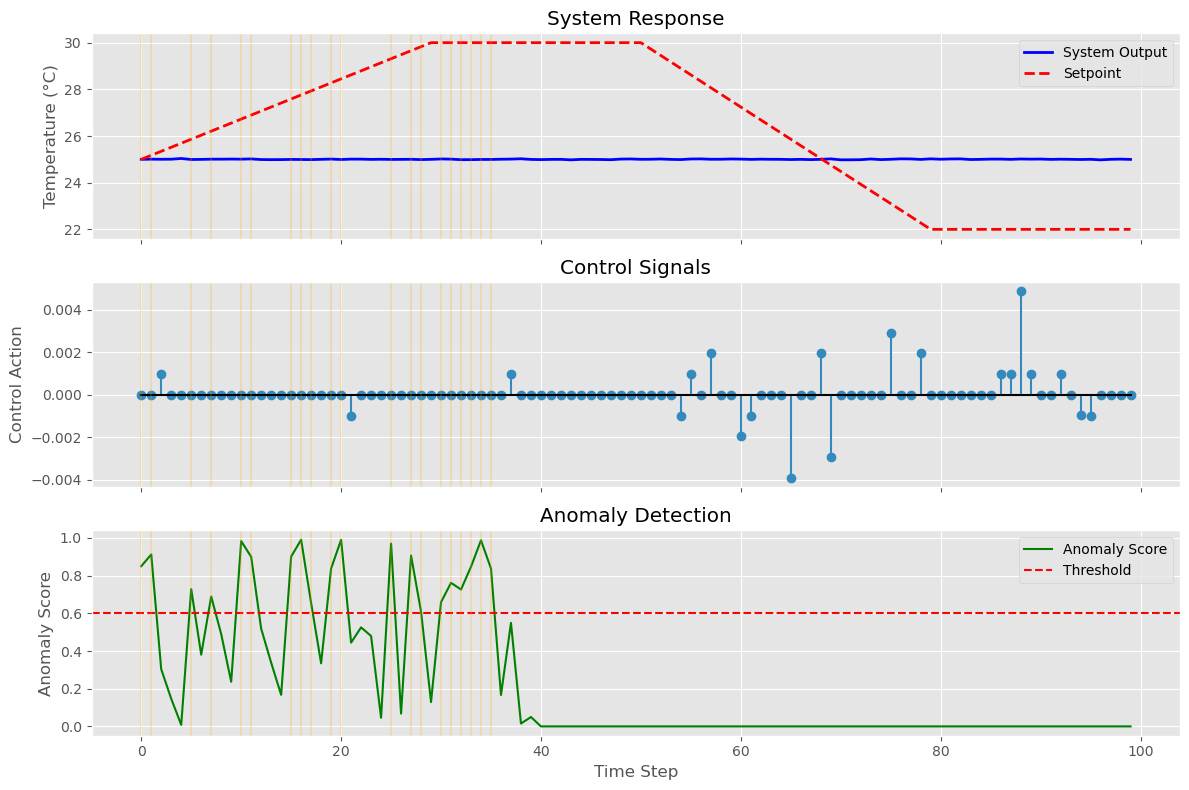

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

# Configuration
config = {
    "horizon": 10,
    "thermal_features": 3,
    "time_series_features": 5,
    "sequence_length": 24,
    "anomaly_threshold": 0.6,
    "control_bounds": (-1.0, 1.0)
}

# Set up plotting
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True

class SystemModel:
    """Physics-based system dynamics model"""
    def __init__(self):
        # Physical parameters (should be tuned to your real system)
        self.thermal_mass = 0.18       # System thermal inertia
        self.heat_coeff = 0.12         # Heat transfer coefficient
        self.ambient_temp = 25.0       # Ambient temperature
        self.response_gain = 0.7       # Control input effectiveness
        self.disturbance_std = 0.01    # Process noise
        
        # State history for second-order dynamics
        self.prev_state = None
        self.prev_control = None
    
    def step(self, state, control_action):
        """Improved physics-based dynamics"""
        new_state = state.copy()
        
        # Initialize history if first step
        if self.prev_state is None:
            self.prev_state = state['output']
            self.prev_control = 0.0
        
        # Calculate heat loss to environment
        heat_loss = self.heat_coeff * (state['output'] - self.ambient_temp)
        
        # System dynamics with inertia term
        temp_change = (self.response_gain * control_action - heat_loss) / self.thermal_mass
        temp_change -= 0.15 * (state['output'] - self.prev_state)  # Damping term
        
        # Update state
        new_output = state['output'] + temp_change
        new_state['output'] = new_output + np.random.normal(0, self.disturbance_std)
        
        # Update history
        self.prev_state = state['output']
        self.prev_control = control_action
        
        return new_state

class HybridModel:
    """Combined prediction and anomaly detection model"""
    def __init__(self):
        # Initialize scalers
        self.thermal_scaler = MinMaxScaler()
        self.ts_scaler = MinMaxScaler()
        
        # Fit with mock data (replace with real data in practice)
        self.thermal_scaler.fit(np.random.rand(100, config["thermal_features"]))
        self.ts_scaler.fit(np.random.rand(100, config["time_series_features"]))
        
        # Model parameters (would be trained in practice)
        self.weights = np.random.randn(10)  # For 5+3+2 features
        
    def predict(self, time_series, thermal):
        """Make prediction with proper feature engineering"""
        # Normalize inputs
        last_timestep = time_series[-1].reshape(1, -1)
        norm_ts = self.ts_scaler.transform(last_timestep)
        norm_thermal = self.thermal_scaler.transform(thermal.reshape(1, -1))
        
        # Feature engineering
        features = np.concatenate([
            norm_ts.ravel(),          # 5 features
            norm_thermal.ravel(),      # 3 features
            [np.mean(norm_ts)],        # 1 feature
            [np.std(norm_thermal)]     # 1 feature
        ]).reshape(1, -1)
        
        # Anomaly score (0-1)
        anomaly_score = 1 / (1 + np.exp(-np.dot(features, self.weights)))
        return float(anomaly_score[0])

class MPCController:
    """Model Predictive Controller with anomaly detection"""
    def __init__(self):
        self.model = HybridModel()
        self.dynamics = SystemModel()
        self.horizon = config["horizon"]
        self.history = {
            'time': [], 'state': [], 'control': [], 
            'setpoint': [], 'anomaly_score': []
        }
        
    def cost_function(self, controls, state, setpoints):
        """MPC cost function with control penalty"""
        total_cost = 0.0
        sim_state = state.copy()
        
        for i, control in enumerate(controls):
            sim_state = self.dynamics.step(sim_state, control)
            tracking_error = (sim_state['output'] - setpoints[i])**2
            control_penalty = 0.1 * control**2  # Penalize large control actions
            total_cost += tracking_error + control_penalty
            
        return total_cost
    
    def detect_anomaly(self, state):
        """Check for abnormal system conditions"""
        score = self.model.predict(state['time_series'], state['thermal'])
        self.history['anomaly_score'].append(score)
        return score > config["anomaly_threshold"]
    
    def compute_control(self, state, setpoints):
        """Calculate optimal control sequence"""
        self.history['state'].append(state['output'])
        self.history['setpoint'].append(setpoints[0])
        self.history['time'].append(len(self.history['time']))
        
        # Safe mode if anomaly detected
        if self.detect_anomaly(state):
            print(f"Anomaly detected! Using safe control at step {len(self.history['time'])}")
            return np.zeros(self.horizon)
        
        # Optimize control sequence
        bounds = [config["control_bounds"] for _ in range(self.horizon)]
        result = minimize(
            self.cost_function,
            x0=np.zeros(self.horizon),
            args=(state, setpoints),
            bounds=bounds,
            method='SLSQP',
            options={'maxiter': 100, 'ftol': 1e-4}
        )
        
        if not result.success:
            print(f"Optimization warning: {result.message}")
            return np.clip(result.x, *config["control_bounds"])
            
        return result.x
    
    def plot_results(self):
        """Generate comprehensive performance plots"""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
        time = self.history['time']
        
        # System response plot
        ax1.plot(time, self.history['state'], 'b-', label='System Output', linewidth=2)
        ax1.plot(time, self.history['setpoint'], 'r--', label='Setpoint', linewidth=2)
        ax1.set_ylabel('Temperature (°C)')
        ax1.legend()
        ax1.set_title('System Response')
        
        # Control actions plot
        ax2.stem(time, self.history['control'], 
                linefmt='C1-', markerfmt='C1o', basefmt='k-')
        ax2.set_ylabel('Control Action')
        ax2.set_title('Control Signals')
        
        # Anomaly detection plot
        ax3.plot(time, self.history['anomaly_score'], 'g-', label='Anomaly Score')
        ax3.axhline(config["anomaly_threshold"], color='r', linestyle='--', label='Threshold')
        ax3.set_ylabel('Anomaly Score')
        ax3.set_xlabel('Time Step')
        ax3.legend()
        ax3.set_title('Anomaly Detection')
        
        # Highlight anomaly periods
        anomalies = np.where(np.array(self.history['anomaly_score']) > 
                           config["anomaly_threshold"])[0]
        if len(anomalies) > 0:
            for ax in [ax1, ax2, ax3]:
                for t in anomalies:
                    ax.axvline(t, color='orange', alpha=0.2)
        
        plt.tight_layout()
        plt.show()

# Simulation Setup
n_steps = 100
setpoints = np.concatenate([
    np.linspace(25, 30, 30),    # Ramp up
    np.ones(20)*30,             # Maintain
    np.linspace(30, 22, 30),    # Cool down
    np.ones(20)*22              # Maintain
])

# Initialize system
controller = MPCController()
current_state = {
    'time_series': np.random.randn(config["sequence_length"], config["time_series_features"]),
    'thermal': np.random.randn(config["thermal_features"]),
    'output': 25.0  # Initial temperature
}

# Run simulation
for i in range(n_steps):
    # Create artificial anomaly between steps 40-45
    if 40 <= i < 45:
        current_state['thermal'] = np.array([8, -3, 10])  # Abnormal sensor readings
    
    # Get setpoints for horizon
    horizon_setpoints = setpoints[i:i+controller.horizon]
    if len(horizon_setpoints) < controller.horizon:
        horizon_setpoints = np.pad(horizon_setpoints, 
                                 (0, controller.horizon - len(horizon_setpoints)),
                                 'edge')
    
    # Compute and apply control
    controls = controller.compute_control(current_state, horizon_setpoints)
    current_state = controller.dynamics.step(current_state, controls[0])
    controller.history['control'].append(controls[0])
    
    # Update time series data
    current_state['time_series'] = np.roll(current_state['time_series'], -1, axis=0)
    current_state['time_series'][-1] = np.random.randn(config["time_series_features"])

# Plot results
controller.plot_results()